In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import matplotlib.pyplot as plt

from utils import *

## Prepare data

In [23]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [24]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
#Validation set is the first sighting of every whale with >1 sightings
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)
#KL: There are 5004 whales (not counting new_whale) and 2073 whales with one sighting,
#so there should be 5004-2073=2931 whales in the validation set
print(len(val_fns))
#KL: this line saves your validation set for everything else to use
pd.to_pickle(val_fns, 'data/val_fns')

2931


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(array([  2.073000e+03,   1.285000e+03,   5.680000e+02,   2.730000e+02, ...,   0.000000e+00,   0.000000e+00,
          0.000000e+00,   1.000000e+00]),
 array([ 1,  2,  3,  4, ..., 70, 71, 72, 73]),
 <a list of 72 Patch objects>)

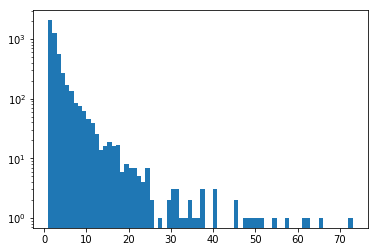

In [5]:
#KL: Plot showing how many whales there are (y axis) with a given number of sightings (x axis)
#KL: For instance, there are 2073 whales with one sighting, 1285 whales with two sightings
#KL: The whale with the most sightings has 73
plt.hist(im_count,range(1,74),log=True)

In [38]:
# pd.to_pickle(val_fns, 'data/val_fns')
val_fns = pd.read_pickle('data/val_fns')

In [39]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [40]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

In [41]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [42]:
df = df[df.Id != 'new_whale']

In [43]:
df.shape

(15697, 3)

In [44]:
df.sighting_count.max()

73.0

In [45]:
df_val = df[df.Image.isin(val_fns)]
df_train = df[~df.Image.isin(val_fns)]
df_train_with_val = df

In [46]:
df_val.shape, df_train.shape, df_train_with_val.shape

((2931, 3), (12766, 3), (15697, 3))

In [47]:
%%time

res = None
#KL: Original resampled training data keeps all whales with > 15 sightings and adds duplicates of all whales with < 15 
#sightings to bring the sighting count up to 15. The result is mostly evenly sampled training data, with any whale with
#>15 sightings over-represented
sample_to = 15

for grp in df_train.groupby('Id'):
    n = grp[1].shape[0]
    additional_rows = grp[1].sample(0 if sample_to < n  else sample_to - n, replace=True)
    rows = pd.concat((grp[1], additional_rows))
    
    if res is None: res = rows
    else: res = pd.concat((res, rows))

CPU times: user 12.2 s, sys: 4 ms, total: 12.2 s
Wall time: 12.2 s


In [48]:
%%time

res_with_val = None
#KL: Original resampled training data keeps all whales with > 15 sightings and adds duplicates of all whales with < 15 
#sightings to bring the sighting count up to 15. The result is mostly evenly sampled training data, with any whale with
#>15 sightings over-represented
sample_to = 15

for grp in df_train_with_val.groupby('Id'):
    n = grp[1].shape[0]
    additional_rows = grp[1].sample(0 if sample_to < n  else sample_to - n, replace=True)
    rows = pd.concat((grp[1], additional_rows))
    
    if res_with_val is None: res_with_val = rows
    else: res_with_val = pd.concat((res_with_val, rows))

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


In [49]:
res.shape, res_with_val.shape

((76174, 3), (76287, 3))

Our training set increased 6-fold, but that is still an amount of data that is okay. I don't think it makes sense to worry about breaking up the data into smaller epochs.

In [50]:
pd.concat((res, df_val))[['Image', 'Id']].to_csv('data/oversampled_train.csv', index=False)
res_with_val[['Image', 'Id']].to_csv('data/oversampled_train_and_val.csv', index=False)

The naming here is not very fortunate, but the idea is that `oversampled_train` has single entries for images in `val_fns` and `oversampled_train_and_val` is both `val` and `train` combined. Meaning, `oversampled_train_and_val` is one we might want to use when retraining on the entire train set.

In [51]:
df = pd.read_csv('data/oversampled_train.csv')

In [52]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [54]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (76174 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train
x: ImageItemList (76174 items)
[Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050)]...
Path: data/train;

Valid: LabelList
y: CategoryList (2931 items)
[Category w_c3d896a, Category w_20df2c5, Category w_64404ac, Category w_a6f9d33, Category w_d3b46e7]...
Path: data/train
x: ImageItemList (2931 items)
[Image (3, 325, 758), Image (3, 497, 1050), Image (3, 450, 1050), Image (3, 667, 1000), Image (3, 347, 1050)]...
Path: data/train;

Test: LabelList
y: CategoryList (7960 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train
x: ImageItemList (7960 items)
[Image (3, 321, 562), Image (3, 333, 1050), Image (3, 600, 1050), Image (3, 372, 1050), Image (3, 405, 630)]...
Path: data/tra